# Converting Pitches from Segment to Time


## Problem: 
The Pitch Matrix for each song in the data set is measured in Segments and not time. A segment is not an even interval of time.  It makes it difficult to compare songs using the pitch data.  

## Outcome:
This anlayis will show how to convert a Pitch Matrix from Segment to Time.  

<b>Note: This segment-to-time conversion will be used later to find the most common "pitch pattern" in a given song.</b>



In [1]:
import os
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py 
import os
import itertools
import re
import functools
import operator 
%matplotlib inline
os.chdir('/Users/mikebrennan/dropbox/Bentley/ma755')
save_load_path = '/Users/mikebrennan/Dropbox/Bentley/MA755'

def get_filenames(path):
    return([get_filenames(path+"/"+entry.name)
            if entry.is_dir() 
            else path+"/"+entry.name 
            for entry 
            in os.scandir(path)
           ])

def unlist(alist):
    return(list(it.chain.from_iterable(alist)
               )
          )

path = "/Users/mikebrennan/desktop/MillionSongSubset/data"
x = unlist(unlist(unlist(get_filenames(path))))
p = re.compile("\.h5$")
y = [filename for filename in x if p.search(filename)]
mss_df=pd.read_pickle(save_load_path+'/brennan2.pkl')

## Custom Functions:
* `get_timbre` / `get_pitch`: Returns the Timbre or Pitch matrix for a given song
* `get_segments`: Returns the start time of each segment for a given song

In [2]:
def get_timbre(file):
    store=pd.HDFStore(y[file],auto_close=True)
    m=(np.matrix(store.root.analysis.segments_timbre.read()))
    store.close()
    return(m)

def get_pitch(file):
    store=pd.HDFStore(y[file],auto_close=True)
    m=(np.matrix(store.root.analysis.segments_pitches.read()))
    store.close()
    return(m)

def get_segments(file):
    store=pd.HDFStore(y[file],auto_close=True)
    m=(np.matrix(store.root.analysis.segments_start.read()))
    store.close()
    return(m)



In [3]:
def get_durations(segments):
    seg_sizes=[]
    for i in range(0,segments.size-1):
        seg_one=segments[0,i]
        seg_two=segments[0,i+1]  
        seg_sizes.append((seg_two-seg_one))
    return(seg_sizes)

## Custom Functions:
* `get_durations`: Takes in segment start times and returns a single-row matrix of segment durations.
* This provides us with segment start time, end time, and duration of the segment.

### Examaple:
Segment|Start Time|Duration
-|-|-
0|0|10
1|10|5
2|15|7
3|22|8
4|30|...

In [4]:
segments_start=np.matrix([0,10,15,22,30])
get_durations(segments_start)

[10, 5, 7, 8]

## Data Exploration:
What do segment durations look like? We can pull the segment duration of every song in the data set and plot it on a histogram.

In [5]:
##Get the durations of every song in the data set
seg_sizes=[]
for file in range(0,10000):
    seg=np.array(get_segments(file))
    seg_sizes.append(get_durations(seg))

(array([  0.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          6.17480000e+04,   2.43288000e+05,   5.17554000e+05,
          6.59765000e+05,   6.02938000e+05,   6.49253000e+05,
          6.09316000e+05,   6.20726000e+05,   7.58955000e+05,
          5.28652000e+05,   4.56531000e+05,   3.42717000e+05,
          3.62462000e+05,   2.82417000e+05,   2.58253000e+05,
          2.04659000e+05,   1.62196000e+05,   1.58853000e+05,
          1.23845000e+05,   1.31909000e+05,   9.90550000e+04,
          9.69070000e+04,   6.83340000e+04,   5.94050000e+04,
          4.81500000e+04,   4.02430000e+04,   4.03630000e+04,
          3.15800000e+04,   3.29780000e+04,   2.45340000e+04,
          2.59310000e+04,   2.00020000e+04,   1.98350000e+04,
          1.71180000e+04,   1.53130000e+04,   1.45330000e+04,
          1.10200000e+04,   1.21920000e+04,   9.34400000e+03,
          1.04100000e+04,   8.41000000e+03,   8.89200000e+03,
          7.57700000e+03,   6.74100000e+03,   6.72000000e+03,
        

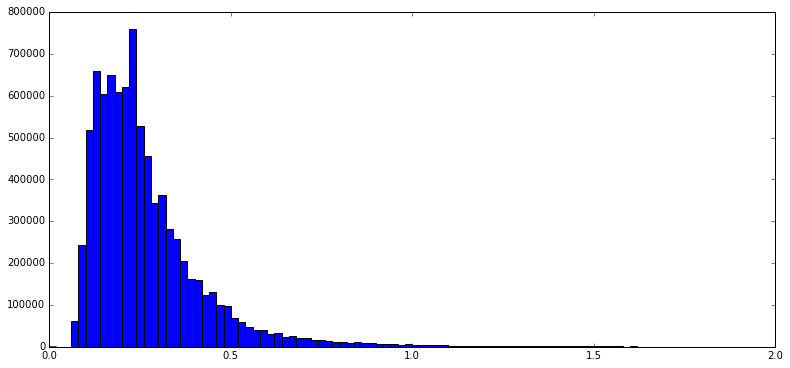

In [6]:
a=unlist(seg_sizes)
fig = plt.figure(1, figsize=(13,6))
plt.hist(a,bins=100,range=[0,2])


--- 

## Even More Custom Functions!
* `segment_convert` Takes in segments plus a `time_slice` measure and generates a conversion table.

In [7]:
def segment_convert(durations, timeslice):
    time_remaining=timeslice #Time remaining in a time slice
    segment_assignments=[]
    pct_starting_slice=0
    pct_ending_slice=0
    number_slices=0
    for i in range(0,len(durations)):
        segment_id=i
        #how many time slices can the segment cover?
        number_slices=durations[i]/time_remaining
        if(math.floor(number_slices) == 0):
            #Then segment can fit within the current timeslice
            #Update the time remaining in the time slice
            time_remaining=time_remaining-durations[i]
            
            #what percent of that time slice does this segment take up?
            pct_starting_slice=durations[i]/timeslice
            number_slices=0
            pct_ending_slice=0
        if(math.floor(number_slices) > 0):
            
            #Then Segments spans multiple time slices
            #1 Fill up the remaining time slice
            pct_starting_slice = time_remaining/timeslice
            dur_remaining = durations[i]-time_remaining
            number_slices = math.floor(dur_remaining/timeslice)
            dur_remaining = dur_remaining - number_slices*timeslice
            #2 Fill up as many time slices as possible
            #  Partially fill the final time slice. 
            pct_ending_slice = dur_remaining / timeslice
            time_remaining = timeslice-dur_remaining
        result=np.matrix([segment_id, round(pct_starting_slice,3), int(round(number_slices)), round(pct_ending_slice,3)])
        segment_assignments.append(pd.DataFrame(result,columns=['seg_id','pct_start','num_slices','pct_end']))
    return(pd.concat(segment_assignments))

## An example conversion table:
Consider the following simple example:

Segment|Duration (seconds)
-|-
0|2
1|0.4
2|1.3
3|2.4
Total|6.1

![hi](https://www.evernote.com/l/AFjc08EUhlFCJL72rTLKLHbbgkGyVvc5MxYB/image.png)

In [8]:
durations=[2,0.4,1.3,2.4]

In [9]:
segment_convert(durations, 0.5)

,seg_id,pct_start,num_slices,pct_end
0,0,1.0,3,0.0
0,1,0.8,0,0.0
0,2,0.2,2,0.4
0,3,0.6,4,0.2


### How to Read this table:
* Segment 0: Runs for a total of four 0.5s time slices
<br>
* Segment 1: Runs for 80% of the next 0.5s time slices

* Segment 2: Runs for...
    - The remaining 20% of the previous time slice. 
    - Two full time 0.5s time slices.
    - 40% of the last time slice.
    
* Segment 3: Runs for...
    - The remaining 60% of the previous time slice.
    - Four full 0.5s time slices.
    - 20% of the last time slice.
    
We can use this conversion table to convert `segment_pitches` and `segments_timbre` from segment-based into periodic measure of `pitch` and `timbre` at an interval of our choosing for all songs.

## Putting it all together.
* `time_convert` Takes in the conversion table plus a `pitch` or `timbre` matrix and converts it into even time intervals.

In [46]:
def time_convert(conversion_table, data):
    empty_matrix=np.matrix([0]*12)
    converted_data=[pd.DataFrame(empty_matrix,columns=['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12'])]
    current_slice=0  
    rows=conversion_table['seg_id'].count()
    for i in range(0,rows):
        
        conv=conversion_table.iloc[i]
        seg_data=pd.DataFrame(data[i],columns=['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12'])
       
        if conv['num_slices']==0:
            converted_data[-1]=converted_data[-1]+conv['pct_start']*seg_data
            converted_data.append(seg_data*conv['pct_end'])
           
            #take weighted percentage of start and add it to the current slice
        if conv['num_slices']>0:
            #take weighted % of start and add to the current slice
            converted_data[-1]=converted_data[-1]+conv['pct_start']*seg_data
            #created full entries Num_slice times            
            for j in range(0,int(conv['num_slices'])):
                converted_data.append(seg_data)
                
            #take weighted % of start and to othe following slice
            converted_data.append(seg_data*conv['pct_end'])
    return (pd.concat(converted_data))


- - -
## The following steps convert the pitch data from Song 0 into samples with a time interval of 0.1 Seconds.
- - -

In [11]:
#Get the segment start times for Song 0
segments=get_segments(0)

#Convert them to durations
dur = get_durations(segments)

#Get the pitch data
pit = get_pitch(0)

#Get the timbre data
tim = get_timbre(0)

#Generate a conversion table for intervals of 0.1s
c=segment_convert(dur, 0.1)

#Convert the pitches
pit_converted = time_convert(c,pit)
tim_converted = time_convert(c,tim)
segments[0,90]



21.648299999999999

- - -
The first 90 <b>segments</b> of Song 10 span a total time of 25.7 <b>seconds</b>.
The plots on the left show the "segment view" of the pitch matrix while the columns on the right show the time view

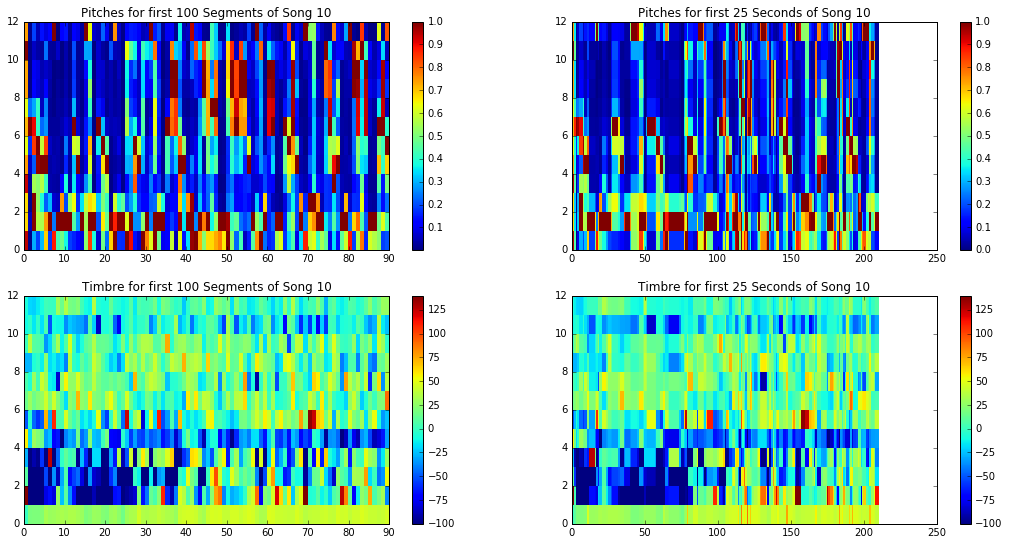

In [13]:
#First 90 segments = First 25 seconds
fig = plt.figure(1, figsize=(18,9))
plt.subplot(2,2,1)
plt.pcolor(pd.DataFrame(pit[0:90]).transpose())
plt.colorbar()
plt.title('Pitches for first 100 Segments of Song 10')

plt.subplot(2,2,2)
plt.pcolor(pit_converted.iloc[0:210].transpose(),vmin=0,vmax=1)
plt.colorbar()
plt.title('Pitches for first 25 Seconds of Song 10')


plt.subplot(2,2,3)
plt.pcolor(pd.DataFrame(tim[0:90]).transpose(),vmin=-100,vmax=140)
plt.colorbar()
plt.title('Timbre for first 100 Segments of Song 10')


plt.subplot(2,2,4)
plt.pcolor(tim_converted.iloc[0:210].transpose(),vmin=-100,vmax=140)
plt.colorbar()
plt.title('Timbre for first 25 Seconds of Song 10')

# Song 10:
https://www.youtube.com/watch?v=vxyZFrIk9lc


In [14]:
#Get the segment start times for Song 10
segments=get_segments(10)

#Convert them to durations
dur = get_durations(segments)

#Get the pitch data
pit = get_pitch(10)

#Get the timbre data
tim = get_timbre(10)

#Generate a conversion table for intervals of 0.1s
c=segment_convert(dur, 0.1)

#Convert the pitches
pit_converted = time_convert(c,pit)
tim_converted = time_convert(c,tim)
segments[0,50]



14.73016

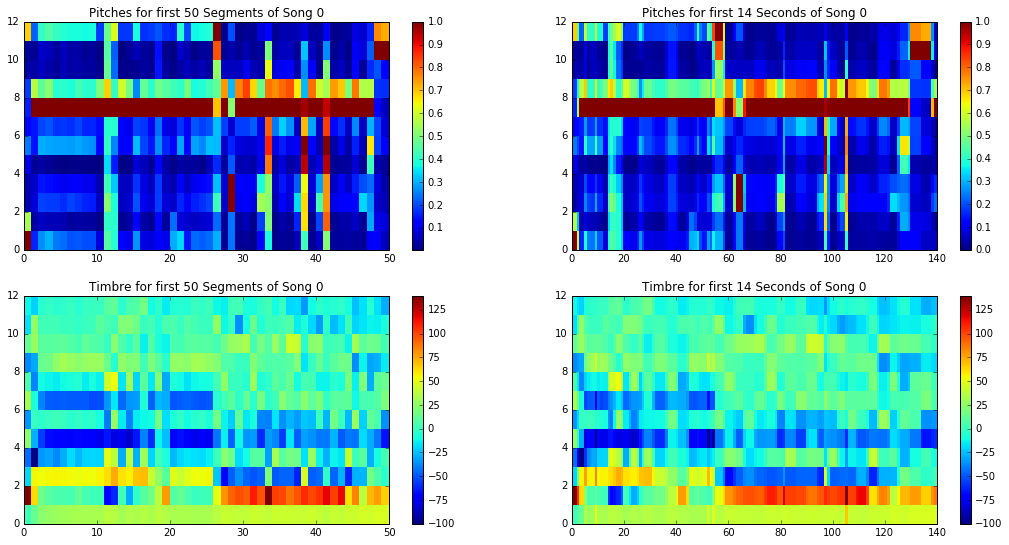

In [15]:
#First 50 segments = First 4.5 seconds
fig = plt.figure(1, figsize=(18,9))
plt.subplot(2,2,1)
plt.pcolor(pd.DataFrame(pit[0:50]).transpose())
plt.colorbar()
plt.title('Pitches for first 50 Segments of Song 0')

plt.subplot(2,2,2)
plt.pcolor(pit_converted.iloc[0:140].transpose(),vmin=0,vmax=1)
plt.colorbar()
plt.title('Pitches for first 14 Seconds of Song 0')


plt.subplot(2,2,3)
plt.pcolor(pd.DataFrame(tim[0:50]).transpose(),vmin=-100,vmax=140)
plt.colorbar()
plt.title('Timbre for first 50 Segments of Song 0')


plt.subplot(2,2,4)
plt.pcolor(tim_converted.iloc[0:140].transpose(),vmin=-100,vmax=140)
plt.colorbar()
plt.title('Timbre for first 14 Seconds of Song 0')

## Song 10:


        

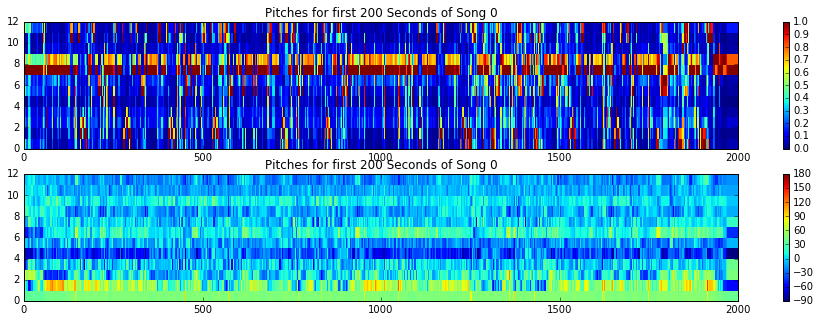

In [22]:
fig = plt.figure(1, figsize=(16,5))
plt.subplot(2,1,1)
plt.pcolor(pit_converted.iloc[0:2000].transpose(),vmin=0,vmax=1)
plt.colorbar()
plt.title('Pitches for first 200 Seconds of Song 0')
plt.subplot(2,1,2)
plt.pcolor(tim_converted.iloc[0:2000].transpose(),vmin=-90,vmax=180)
plt.colorbar()
plt.title('Pitches for first 200 Seconds of Song 0')


## Concluding Points:

By converting segments to time we are able to view pitches over time (as we actually hear them) and analyize this data.  Next week I will continue to explore how we can use this new time-based data to find common pitch patterns within a song and extract measures of song structure.